In [75]:
library(data.table)
library(lubridate)
library(forecast)
library(ggplot2)
library(rpart)
library(rattle)

# Introduction

In this homework, production values of small solar power plants around Kayseri will be analyzed and a model created to predict production values in between 2019-09-01 and 2021-12-25. In addition, the prediction will be held by assuming only the t-1 dataset available on day t, and only t+1 will be predicted. In addition, the prediction will be at an hourly level. 

In the beginning, we have a dataset including temperature, humidity, a short version of downward shortwave radiation, and cloud cover data for each day and hour. In addition, these features represent 25 different grids of Turkey, so somehow they are correlated. To overcome this situation, correlation analysis will be tried and PCA will be implemented to get independent features. Each feature will be controlled individually( with all grids), so 4 different PCA and Correlation analyses will be in the code.

After getting proper features, different linear regression will be tried to explain the target variable(production). The main technique will be adding new features to the last created linear regression model. After finding a good model in terms of the assumption of the linear regression, EBLR (explainable boosted linear regression) technique will be used with different iterations.

At the end of the code, the performance of the obtained model will be compared with a base model lag 48 by using WMAPE (daily weighted mean absolute percentage error) values. 

**Note:** I updated my sliding window technique in the final exam and added additional comments into created final exam notebook to complete homework 4.

# Context
(In order to get specified techniques rapidly, a context part is added to Notebook.)

1. [Data  Loading](#1)
1. [Data Preparation](#2)
1. [Model](#3)
1. [Predictions with Obtained Model](#4)
1. [Base Model](#5)
1. [Results](#6)
1. [Last Comment and Conclusion](#7)

<a id="1"></a>
# Data Loading

In [2]:
data=fread("production_with_weather_data/production_with_weather_data.csv")

In [3]:
str(data)

Classes 'data.table' and 'data.frame':	20280 obs. of  178 variables:
 $ date                               : IDate, format: "2019-09-01" "2019-09-01" ...
 $ hour                               : int  0 1 2 3 4 5 6 7 8 9 ...
 $ production                         : num  0 0 0 0 0 ...
 $ DSWRF_surface_38_35                : num  0 0 0 0 0 0 0 9 51 115 ...
 $ DSWRF_surface_38_35.25             : num  0 0 0 0 0 0 0 9 52 117 ...
 $ DSWRF_surface_38_35.5              : num  0 0 0 0 0 0 0 9 51 114 ...
 $ DSWRF_surface_38_35.75             : num  0 0 0 0 0 0 0 10 52 115 ...
 $ DSWRF_surface_38_36                : num  0 0 0 0 0 0 0 10 51 114 ...
 $ DSWRF_surface_38.25_35             : num  0 0 0 0 0 0 0 9 50 112 ...
 $ DSWRF_surface_38.25_35.25          : num  0 0 0 0 0 0 0 9 50 112 ...
 $ DSWRF_surface_38.25_35.5           : num  0 0 0 0 0 0 0 9 51 114 ...
 $ DSWRF_surface_38.25_35.75          : num  0 0 0 0 0 0 0 10 51 115 ...
 $ DSWRF_surface_38.25_36             : num  0 0 0 0 0 0 0 10 52 11

In [4]:
data[date=="2021-12-18",]

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2021-12-18,0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,273.397,273.707,273.717,272.057,272.117,273.017,273.037,273.057,273.087,273.197
2021-12-18,1,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,273.117,273.507,273.767,271.917,271.847,272.967,272.627,272.907,272.907,273.017
2021-12-18,2,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,272.975,273.255,273.625,271.825,271.675,272.995,272.675,272.495,272.825,272.815
2021-12-18,3,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,272.918,273.118,273.488,271.848,271.538,272.778,272.768,272.228,272.728,272.628
2021-12-18,4,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,272.805,272.965,273.405,271.695,271.235,272.415,272.825,272.045,272.525,272.465
2021-12-18,5,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,271.895,272.595,273.175,271.605,271.025,271.555,272.335,272.005,272.335,272.415
2021-12-18,6,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,271.427,272.547,272.917,271.487,270.667,271.187,272.247,271.817,272.187,272.287
2021-12-18,7,0.000623,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,270.654,271.614,272.304,271.254,270.284,270.904,271.564,271.054,271.854,272.264
2021-12-18,8,0.066399,0.04,0.06,0.06,0.08,0.10,0.02,0.02,...,270.427,271.307,272.167,270.087,269.747,270.787,271.537,270.627,271.057,271.407
2021-12-18,9,1.557348,10.14,9.88,7.98,7.14,5.76,7.76,4.64,...,271.266,271.396,272.396,270.626,270.286,271.896,272.036,271.186,271.706,271.436


### General Information of dataset

In [5]:
summary(data)

      date                 hour         production       DSWRF_surface_38_35
 Min.   :2019-09-01   Min.   : 0.00   Min.   :  0.0000   Min.   :  0.0      
 1st Qu.:2020-03-30   1st Qu.: 5.75   1st Qu.:  0.0004   1st Qu.:  0.0      
 Median :2020-10-27   Median :11.50   Median :  1.4348   Median : 76.0      
 Mean   :2020-10-27   Mean   :11.50   Mean   : 67.5243   Mean   :222.6      
 3rd Qu.:2021-05-26   3rd Qu.:17.25   3rd Qu.:128.0000   3rd Qu.:410.0      
 Max.   :2021-12-25   Max.   :23.00   Max.   :330.3170   Max.   :970.0      
                                                         NA's   :4          
 DSWRF_surface_38_35.25 DSWRF_surface_38_35.5 DSWRF_surface_38_35.75
 Min.   :  0.00         Min.   :  0.00        Min.   :  0.0         
 1st Qu.:  0.00         1st Qu.:  0.00        1st Qu.:  0.0         
 Median : 74.21         Median : 64.25        Median : 60.0         
 Mean   :221.17         Mean   :217.09        Mean   :214.6         
 3rd Qu.:403.80         3rd Qu.:396.16 

# Performance Control Fuction

In [6]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

<a id="2"></a>
# Data Preparation

## NA Control

There are some NA values data, which is limited compared to the whole dataset. Indeed, these NA values can be removed by considering the number of NA values in the data. However, some NA values are located in the test period. By knowing this fact, we have to fill NA values with a number. These places can be filled by using the interpolation or Observation Carried techniques, or with a constant value. In my case, my computer failed to achieve desired datasets with the first 2 methods because of a lack of computing power. So, I preferred to last technique.

### DSWRF Surface

In [7]:
data[is.na(DSWRF_surface_38_35),]

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2021-06-09,19,7.90120,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-11-26,14,189.84030,NA,NA,NA,NA,NA,NA,NA,...,284.835,284.405,283.225,282.735,282.425,283.215,283.015,282.375,282.495,282.715
2021-12-22,18,0.00000,NA,NA,NA,NA,NA,NA,NA,...,269.097,269.567,268.067,263.837,264.207,268.907,269.037,268.077,267.567,267.297
2021-12-25,16,46.84658,NA,NA,NA,NA,NA,NA,NA,...,275.997,275.377,275.497,271.187,269.877,274.217,274.307,273.747,273.017,273.247


### RH 2 Above

In [8]:
data[is.na(RH_2.m.above.ground_38_35),]

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2021-06-09,19,7.901200,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-12-01,7,0.260118,0,0,0,0,0,0,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-12-13,0,0.000000,0,0,0,0,0,0,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### TCDC Entire

In [9]:
data[is.na(TCDC_entire.atmosphere_38_35),]

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2021-06-09,19,7.9012,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### TCDC High

In [10]:
data[is.na(TCDC_high.cloud.layer_38_35),]

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2021-06-09,19,7.9012,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### TCDC Low

In [11]:
data[is.na(TCDC_low.cloud.layer_38_35),]

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2021-06-09,19,7.9012,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-11-26,16,35.4222,272.98,269.88,235.88,183.32,79.18,260.46,251.68,...,285.017,284.447,283.517,282.757,282.217,283.637,283.197,282.347,282.457,282.957


### TCDC Middle

In [12]:
data[is.na(TCDC_middle.cloud.layer_38_35),]

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2021-06-09,19,7.9012,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### TMP_2 m above ground

In [13]:
data[is.na(TMP_2.m.above.ground_38_35),]

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2021-06-09,19,7.901200,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-12-01,7,0.260118,0,0,0,0,0,0,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-12-13,0,0.000000,0,0,0,0,0,0,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Filling NA values

In [14]:
data=as.data.frame(data)

In [15]:
data[is.na(data)] = 0

In [16]:
data=as.data.table(data)

## Correlation Control and PCA

Features, important and representing different information, will be controlled to understand how much datasets are correlated. By looking that the PCA technique can be applied to reduce the multicollinearity problem in the dataset.

In [17]:
corr_info=cor(data[,-c("date", "hour","production")])

### DSWRF Correlation and PCA

In [18]:
corr_info[c(seq(1:25)),
          c(seq(1:25))]

,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,DSWRF_surface_38.25_35.5,DSWRF_surface_38.25_35.75,DSWRF_surface_38.25_36,...,DSWRF_surface_38.75_35,DSWRF_surface_38.75_35.25,DSWRF_surface_38.75_35.5,DSWRF_surface_38.75_35.75,DSWRF_surface_38.75_36,DSWRF_surface_39_35,DSWRF_surface_39_35.25,DSWRF_surface_39_35.5,DSWRF_surface_39_35.75,DSWRF_surface_39_36
DSWRF_surface_38_35,1.0000000,0.9904905,0.9756940,0.9666716,0.9616658,0.9845674,0.9839592,0.9857361,0.9827592,0.9767395,...,0.9771789,0.9783389,0.9781055,0.9791936,0.9792634,0.9729945,0.9745354,0.9753951,0.9751265,0.9763171
DSWRF_surface_38_35.25,0.9904905,1.0000000,0.9805469,0.9683162,0.9627560,0.9791032,0.9789085,0.9813312,0.9799078,0.9760057,...,0.9698303,0.9709328,0.9714403,0.9753304,0.9761686,0.9659677,0.9670112,0.9678189,0.9693767,0.9713832
DSWRF_surface_38_35.5,0.9756940,0.9805469,1.0000000,0.9886998,0.9818886,0.9776628,0.9779618,0.9829440,0.9839182,0.9844272,...,0.9715609,0.9724283,0.9716199,0.9747676,0.9761874,0.9686376,0.9699695,0.9697605,0.9703723,0.9711701
DSWRF_surface_38_35.75,0.9666716,0.9683162,0.9886998,1.0000000,0.9931332,0.9721333,0.9717686,0.9769114,0.9797054,0.9845785,...,0.9678871,0.9681165,0.9667596,0.9704913,0.9733658,0.9641027,0.9662090,0.9661741,0.9670389,0.9684315
DSWRF_surface_38_36,0.9616658,0.9627560,0.9818886,0.9931332,1.0000000,0.9696342,0.9702672,0.9730505,0.9751702,0.9823707,...,0.9673840,0.9660493,0.9641341,0.9664755,0.9700756,0.9643217,0.9657987,0.9649843,0.9652347,0.9660412
DSWRF_surface_38.25_35,0.9845674,0.9791032,0.9776628,0.9721333,0.9696342,1.0000000,0.9933087,0.9875376,0.9818822,0.9775004,...,0.9853539,0.9851477,0.9820103,0.9833088,0.9844364,0.9813265,0.9824565,0.9811208,0.9806121,0.9817129
DSWRF_surface_38.25_35.25,0.9839592,0.9789085,0.9779618,0.9717686,0.9702672,0.9933087,1.0000000,0.9924650,0.9829337,0.9780715,...,0.9846115,0.9850728,0.9833145,0.9835774,0.9839569,0.9790553,0.9807868,0.9804350,0.9814345,0.9820100
DSWRF_surface_38.25_35.5,0.9857361,0.9813312,0.9829440,0.9769114,0.9730505,0.9875376,0.9924650,1.0000000,0.9928990,0.9845278,...,0.9824002,0.9842786,0.9846168,0.9866286,0.9875574,0.9774984,0.9800328,0.9817257,0.9828701,0.9838099
DSWRF_surface_38.25_35.75,0.9827592,0.9799078,0.9839182,0.9797054,0.9751702,0.9818822,0.9829337,0.9928990,1.0000000,0.9921250,...,0.9774010,0.9797757,0.9804890,0.9838427,0.9864246,0.9735398,0.9764061,0.9785538,0.9799022,0.9817658
DSWRF_surface_38.25_36,0.9767395,0.9760057,0.9844272,0.9845785,0.9823707,0.9775004,0.9780715,0.9845278,0.9921250,1.0000000,...,0.9723338,0.9744127,0.9741945,0.9778041,0.9817088,0.9687140,0.9718155,0.9732021,0.9741422,0.9768938


### PCA for DSWRF

In [19]:
pca_DSWRF=princomp(data[,c(seq(1:25)+3),with=F])
summary(pca_DSWRF,loadings=T)

Importance of components:
                            Comp.1       Comp.2      Comp.3       Comp.4
Standard deviation     1355.718244 97.471125474 71.41600188 63.468007742
Proportion of Variance    0.981408  0.005072975  0.00272334  0.002150901
Cumulative Proportion     0.981408  0.986481001  0.98920434  0.991355242
                             Comp.5       Comp.6       Comp.7       Comp.8
Standard deviation     47.117861222 44.180679994 4.219292e+01 3.641901e+01
Proportion of Variance  0.001185446  0.001042259 9.505827e-04 7.082179e-04
Cumulative Proportion   0.992540688  0.993582947 9.945335e-01 9.952417e-01
                             Comp.9      Comp.10      Comp.11      Comp.12
Standard deviation     3.504846e+01 3.275265e+01 3.117240e+01 2.868492e+01
Proportion of Variance 6.559166e-04 5.728009e-04 5.188611e-04 4.393574e-04
Cumulative Proportion  9.958977e-01 9.964705e-01 9.969893e-01 9.974287e-01
                            Comp.13      Comp.14      Comp.15      Comp.16
Standar

By looking the obtained result, 1 Component is enought to explain variance in the dataset (Proportion of Variance is above 98%).

In [20]:
data[, DSWRF:=pca_DSWRF$scores[,1]]

### RH Correlation and PCA

In [21]:
corr_info[c(seq(1:25)+25),
          c(seq(1:25)+25)]

,RH_2.m.above.ground_38_35,RH_2.m.above.ground_38_35.25,RH_2.m.above.ground_38_35.5,RH_2.m.above.ground_38_35.75,RH_2.m.above.ground_38_36,RH_2.m.above.ground_38.25_35,RH_2.m.above.ground_38.25_35.25,RH_2.m.above.ground_38.25_35.5,RH_2.m.above.ground_38.25_35.75,RH_2.m.above.ground_38.25_36,...,RH_2.m.above.ground_38.75_35,RH_2.m.above.ground_38.75_35.25,RH_2.m.above.ground_38.75_35.5,RH_2.m.above.ground_38.75_35.75,RH_2.m.above.ground_38.75_36,RH_2.m.above.ground_39_35,RH_2.m.above.ground_39_35.25,RH_2.m.above.ground_39_35.5,RH_2.m.above.ground_39_35.75,RH_2.m.above.ground_39_36
RH_2.m.above.ground_38_35,1.0000000,0.9522435,0.8300898,0.7804179,0.7409519,0.8417733,0.8236387,0.8499575,0.8472264,0.8366016,...,0.8259306,0.8277458,0.8496947,0.8787610,0.8596904,0.8238295,0.8206713,0.8356781,0.8282021,0.8476857
RH_2.m.above.ground_38_35.25,0.9522435,1.0000000,0.8457578,0.8084543,0.7665574,0.7863867,0.7800640,0.8094246,0.8147805,0.8396472,...,0.7480471,0.7476897,0.7747651,0.8316443,0.8204763,0.7482270,0.7427132,0.7658363,0.7658812,0.7846531
RH_2.m.above.ground_38_35.5,0.8300898,0.8457578,1.0000000,0.9656570,0.9322572,0.8549082,0.8865233,0.9288304,0.9300112,0.9393349,...,0.7878282,0.7804951,0.7964933,0.8583025,0.8622121,0.7633746,0.7616248,0.7900106,0.8082540,0.8045313
RH_2.m.above.ground_38_35.75,0.7804179,0.8084543,0.9656570,1.0000000,0.9765752,0.8073396,0.8427441,0.8950613,0.9130496,0.9426559,...,0.7402517,0.7362933,0.7540663,0.8195196,0.8319880,0.7153931,0.7201405,0.7504647,0.7690991,0.7670717
RH_2.m.above.ground_38_36,0.7409519,0.7665574,0.9322572,0.9765752,1.0000000,0.7806096,0.8189545,0.8680055,0.8911830,0.9222925,...,0.7147111,0.7136622,0.7307779,0.7878111,0.8069386,0.6897324,0.7001409,0.7305586,0.7484165,0.7424834
RH_2.m.above.ground_38.25_35,0.8417733,0.7863867,0.8549082,0.8073396,0.7806096,1.0000000,0.9711681,0.9342354,0.9028770,0.8621080,...,0.9389841,0.9346397,0.9235725,0.9158987,0.9057576,0.9057687,0.9059081,0.9122757,0.9180952,0.9025296
RH_2.m.above.ground_38.25_35.25,0.8236387,0.7800640,0.8865233,0.8427441,0.8189545,0.9711681,1.0000000,0.9661358,0.9258499,0.8869039,...,0.9159078,0.9120437,0.9079595,0.9068345,0.9025589,0.8805512,0.8804884,0.8909938,0.9025587,0.8872755
RH_2.m.above.ground_38.25_35.5,0.8499575,0.8094246,0.9288304,0.8950613,0.8680055,0.9342354,0.9661358,1.0000000,0.9764855,0.9377152,...,0.8922401,0.8899353,0.8982170,0.9198295,0.9202292,0.8628520,0.8674883,0.8850701,0.8964496,0.8896784
RH_2.m.above.ground_38.25_35.75,0.8472264,0.8147805,0.9300112,0.9130496,0.8911830,0.9028770,0.9258499,0.9764855,1.0000000,0.9672266,...,0.8652053,0.8650475,0.8793162,0.9164095,0.9245549,0.8403869,0.8494988,0.8717632,0.8876020,0.8850622
RH_2.m.above.ground_38.25_36,0.8366016,0.8396472,0.9393349,0.9426559,0.9222925,0.8621080,0.8869039,0.9377152,0.9672266,1.0000000,...,0.8170723,0.8161460,0.8329937,0.8985967,0.9127020,0.7962535,0.8052898,0.8333716,0.8524899,0.8557504


### PCA for RH

In [22]:
pca_RH=princomp(data[,c(seq(1:25)+28),with=F])
summary(pca_RH,loadings=T)

Importance of components:
                            Comp.1      Comp.2     Comp.3      Comp.4
Standard deviation     107.3189487 25.57745645 15.5932970 11.75447138
Proportion of Variance   0.8872713  0.05039858  0.0187318  0.01064412
Cumulative Proportion    0.8872713  0.93766992  0.9564017  0.96704584
                             Comp.5      Comp.6     Comp.7      Comp.8
Standard deviation     10.212374581 7.596742322 6.41374991 5.633716158
Proportion of Variance  0.008034468 0.004445887 0.00316904 0.002445083
Cumulative Proportion   0.975080307 0.979526194 0.98269523 0.985140317
                            Comp.9     Comp.10     Comp.11    Comp.12
Standard deviation     5.445544958 5.004543161 4.532517902 4.11763670
Proportion of Variance 0.002284475 0.001929445 0.001582642 0.00130617
Cumulative Proportion  0.987424791 0.989354237 0.990936879 0.99224305
                           Comp.13     Comp.14      Comp.15     Comp.16
Standard deviation     3.997810998 3.586206241 3.421294561

By looking the obtained result, 1 Component is enought to explain variance in the dataset (Proportion of Variance is above 88%).

In [23]:
data[, RH:=pca_RH$scores[,1]]

### TCDC

In [24]:
corr_info[c(seq(1:100)+50),
          c(seq(1:100)+50)]

,TCDC_entire.atmosphere_38_35,TCDC_entire.atmosphere_38_35.25,TCDC_entire.atmosphere_38_35.5,TCDC_entire.atmosphere_38_35.75,TCDC_entire.atmosphere_38_36,TCDC_entire.atmosphere_38.25_35,TCDC_entire.atmosphere_38.25_35.25,TCDC_entire.atmosphere_38.25_35.5,TCDC_entire.atmosphere_38.25_35.75,TCDC_entire.atmosphere_38.25_36,...,TCDC_middle.cloud.layer_38.75_35,TCDC_middle.cloud.layer_38.75_35.25,TCDC_middle.cloud.layer_38.75_35.5,TCDC_middle.cloud.layer_38.75_35.75,TCDC_middle.cloud.layer_38.75_36,TCDC_middle.cloud.layer_39_35,TCDC_middle.cloud.layer_39_35.25,TCDC_middle.cloud.layer_39_35.5,TCDC_middle.cloud.layer_39_35.75,TCDC_middle.cloud.layer_39_36
TCDC_entire.atmosphere_38_35,1.0000000,0.9399846,0.8415933,0.7874165,0.7315421,0.8830276,0.8879603,0.8708085,0.8493772,0.7991478,...,0.6101190,0.6129339,0.6072813,0.6197443,0.6243477,0.5853561,0.6000594,0.6024028,0.5998853,0.5950832
TCDC_entire.atmosphere_38_35.25,0.9399846,1.0000000,0.8751049,0.8134476,0.7600018,0.8435488,0.8642209,0.8726997,0.8610925,0.8152210,...,0.5900665,0.5946823,0.5984005,0.6174910,0.6179679,0.5634853,0.5784740,0.5856411,0.5907973,0.5900873
TCDC_entire.atmosphere_38_35.5,0.8415933,0.8751049,1.0000000,0.9116921,0.8514764,0.8118428,0.8431645,0.8760072,0.8788274,0.8658435,...,0.6012776,0.6059325,0.6012640,0.6138570,0.6187028,0.5842168,0.5944830,0.5938501,0.5931534,0.5856746
TCDC_entire.atmosphere_38_35.75,0.7874165,0.8134476,0.9116921,1.0000000,0.9354342,0.7699358,0.7880050,0.8282994,0.8495486,0.8822075,...,0.6016323,0.6038591,0.5963002,0.6105753,0.6230068,0.5883027,0.5981217,0.5985024,0.5965815,0.5916023
TCDC_entire.atmosphere_38_36,0.7315421,0.7600018,0.8514764,0.9354342,1.0000000,0.7347067,0.7438411,0.7682038,0.8007695,0.8578319,...,0.6130914,0.6162189,0.6090431,0.6234123,0.6357361,0.5999480,0.6095994,0.6095419,0.6093779,0.6064044
TCDC_entire.atmosphere_38.25_35,0.8830276,0.8435488,0.8118428,0.7699358,0.7347067,1.0000000,0.9096265,0.8551017,0.8235227,0.7750250,...,0.6739662,0.6708581,0.6530195,0.6589117,0.6562906,0.6469625,0.6570391,0.6573777,0.6494990,0.6382558
TCDC_entire.atmosphere_38.25_35.25,0.8879603,0.8642209,0.8431645,0.7880050,0.7438411,0.9096265,1.0000000,0.9245106,0.8688135,0.8067020,...,0.6563434,0.6656546,0.6647751,0.6713644,0.6710932,0.6261690,0.6462762,0.6513917,0.6509452,0.6445339
TCDC_entire.atmosphere_38.25_35.5,0.8708085,0.8726997,0.8760072,0.8282994,0.7682038,0.8551017,0.9245106,1.0000000,0.9351768,0.8477028,...,0.6245659,0.6377115,0.6432080,0.6570586,0.6614378,0.6013169,0.6206556,0.6276027,0.6336555,0.6284016
TCDC_entire.atmosphere_38.25_35.75,0.8493772,0.8610925,0.8788274,0.8495486,0.8007695,0.8235227,0.8688135,0.9351768,1.0000000,0.8911273,...,0.6119298,0.6218599,0.6251878,0.6496770,0.6604166,0.5892958,0.6083624,0.6167725,0.6210445,0.6234739
TCDC_entire.atmosphere_38.25_36,0.7991478,0.8152210,0.8658435,0.8822075,0.8578319,0.7750250,0.8067020,0.8477028,0.8911273,1.0000000,...,0.5938238,0.6034644,0.6073686,0.6276878,0.6451441,0.5812814,0.5970957,0.6107147,0.6112446,0.6113476


### PCA for TCDC

In [25]:
pca_TCDC=princomp(data[,seq(1:100)+53,with=F])
summary(pca_TCDC,loadings=T)

Importance of components:
                            Comp.1      Comp.2      Comp.3      Comp.4
Standard deviation     286.5215458 132.8744067 81.61790454 60.86427163
Proportion of Variance   0.6239611   0.1341917  0.05063068  0.02815579
Cumulative Proportion    0.6239611   0.7581527  0.80878343  0.83693922
                           Comp.5      Comp.6      Comp.7      Comp.8
Standard deviation     48.7485259 45.20786802 41.49078284 38.07801407
Proportion of Variance  0.0180620  0.01553356  0.01308417  0.01102025
Cumulative Proportion   0.8550012  0.87053479  0.88361896  0.89463921
                            Comp.9     Comp.10      Comp.11      Comp.12
Standard deviation     30.98250254 27.98257971 25.737043546 25.544240966
Proportion of Variance  0.00729585  0.00595139  0.005034545  0.004959398
Cumulative Proportion   0.90193506  0.90788645  0.912920992  0.917880390
                            Comp.13      Comp.14     Comp.15      Comp.16
Standard deviation     23.881134974 22.89315

By looking the obtained result, 2 Component is enought to explain variance in the dataset (Proportion of Variance is above 75%).

In [26]:
data[, TCDC1:=pca_TCDC$scores[,1]]
data[, TCDC2:=pca_TCDC$scores[,2]]

### Temperature

In [27]:
corr_info[c(seq(1:25)+150),
          c(seq(1:25)+150)]

,TMP_2.m.above.ground_38_35,TMP_2.m.above.ground_38_35.25,TMP_2.m.above.ground_38_35.5,TMP_2.m.above.ground_38_35.75,TMP_2.m.above.ground_38_36,TMP_2.m.above.ground_38.25_35,TMP_2.m.above.ground_38.25_35.25,TMP_2.m.above.ground_38.25_35.5,TMP_2.m.above.ground_38.25_35.75,TMP_2.m.above.ground_38.25_36,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
TMP_2.m.above.ground_38_35,1.0000000,0.9944146,0.9868613,0.9814329,0.9749205,0.9863136,0.9838777,0.9884747,0.9876849,0.9851518,...,0.9827588,0.9810837,0.9841609,0.9868540,0.9828151,0.9820004,0.9811765,0.9837161,0.9810200,0.9830186
TMP_2.m.above.ground_38_35.25,0.9944146,1.0000000,0.9883620,0.9856101,0.9790070,0.9789646,0.9769827,0.9819216,0.9825280,0.9854704,...,0.9731166,0.9706026,0.9746439,0.9816102,0.9791267,0.9738449,0.9718471,0.9756930,0.9742247,0.9765111
TMP_2.m.above.ground_38_35.5,0.9868613,0.9883620,1.0000000,0.9953191,0.9911973,0.9847548,0.9849138,0.9904959,0.9916671,0.9926968,...,0.9776446,0.9762084,0.9803252,0.9864996,0.9858246,0.9770850,0.9771079,0.9814629,0.9820198,0.9822336
TMP_2.m.above.ground_38_35.75,0.9814329,0.9856101,0.9953191,1.0000000,0.9970369,0.9782740,0.9777524,0.9840293,0.9873020,0.9917954,...,0.9697415,0.9688339,0.9732778,0.9797440,0.9807188,0.9687668,0.9698754,0.9749736,0.9757874,0.9758223
TMP_2.m.above.ground_38_36,0.9749205,0.9790070,0.9911973,0.9970369,1.0000000,0.9749057,0.9747936,0.9806166,0.9844838,0.9890093,...,0.9655963,0.9655013,0.9697441,0.9749918,0.9772190,0.9639100,0.9665937,0.9720417,0.9731476,0.9721169
TMP_2.m.above.ground_38.25_35,0.9863136,0.9789646,0.9847548,0.9782740,0.9749057,1.0000000,0.9969193,0.9936150,0.9896673,0.9830328,...,0.9928092,0.9927381,0.9921412,0.9880033,0.9863490,0.9896519,0.9904426,0.9910506,0.9907887,0.9897990
TMP_2.m.above.ground_38.25_35.25,0.9838777,0.9769827,0.9849138,0.9777524,0.9747936,0.9969193,1.0000000,0.9957127,0.9901588,0.9832026,...,0.9911981,0.9909880,0.9911760,0.9871899,0.9861114,0.9879174,0.9887306,0.9895263,0.9897656,0.9889318
TMP_2.m.above.ground_38.25_35.5,0.9884747,0.9819216,0.9904959,0.9840293,0.9806166,0.9936150,0.9957127,1.0000000,0.9969508,0.9905291,...,0.9890663,0.9890414,0.9912681,0.9912598,0.9899325,0.9862330,0.9880440,0.9904144,0.9901052,0.9898891
TMP_2.m.above.ground_38.25_35.75,0.9876849,0.9825280,0.9916671,0.9873020,0.9844838,0.9896673,0.9901588,0.9969508,1.0000000,0.9947879,...,0.9843509,0.9849250,0.9881011,0.9907912,0.9909452,0.9816585,0.9845547,0.9880378,0.9885192,0.9886033
TMP_2.m.above.ground_38.25_36,0.9851518,0.9854704,0.9926968,0.9917954,0.9890093,0.9830328,0.9832026,0.9905291,0.9947879,1.0000000,...,0.9765903,0.9768779,0.9810944,0.9890240,0.9904975,0.9750351,0.9774838,0.9824977,0.9838456,0.9846129


### PCA for Temperature

In [28]:
pca_Temp=princomp(data[,c(seq(1:25)+153),with=F])
summary(pca_Temp,loadings=T)

Importance of components:
                           Comp.1      Comp.2      Comp.3      Comp.4
Standard deviation     48.7772773 3.588876932 2.087088665 1.844480559
Proportion of Variance  0.9874464 0.005345589 0.001807841 0.001411974
Cumulative Proportion   0.9874464 0.992791974 0.994599815 0.996011788
                             Comp.5       Comp.6       Comp.7       Comp.8
Standard deviation     1.5282335079 1.1828248760 0.9580466117 0.8311298128
Proportion of Variance 0.0009692992 0.0005806565 0.0003809357 0.0002866924
Cumulative Proportion  0.9969810875 0.9975617440 0.9979426797 0.9982293721
                             Comp.9     Comp.10      Comp.11      Comp.12
Standard deviation     0.7649366504 0.716423777 0.6606478206 0.6346833237
Proportion of Variance 0.0002428451 0.000213019 0.0001811417 0.0001671832
Cumulative Proportion  0.9984722172 0.998685236 0.9988663779 0.9990335611
                            Comp.13      Comp.14      Comp.15      Comp.16
Standard deviation     

By looking the obtained result, 1 Component is enought to explain variance in the dataset (Proportion of Variance is above 98%).

In [29]:
data[, Temp:=pca_Temp$scores[,1]]

<a id="3"></a>
# Model

First of all data must be controlled visually to understand 

### Visual Control

In [30]:
data[,datetime:=ymd(date)+dhours(hour)]
data=data[order(datetime)] 

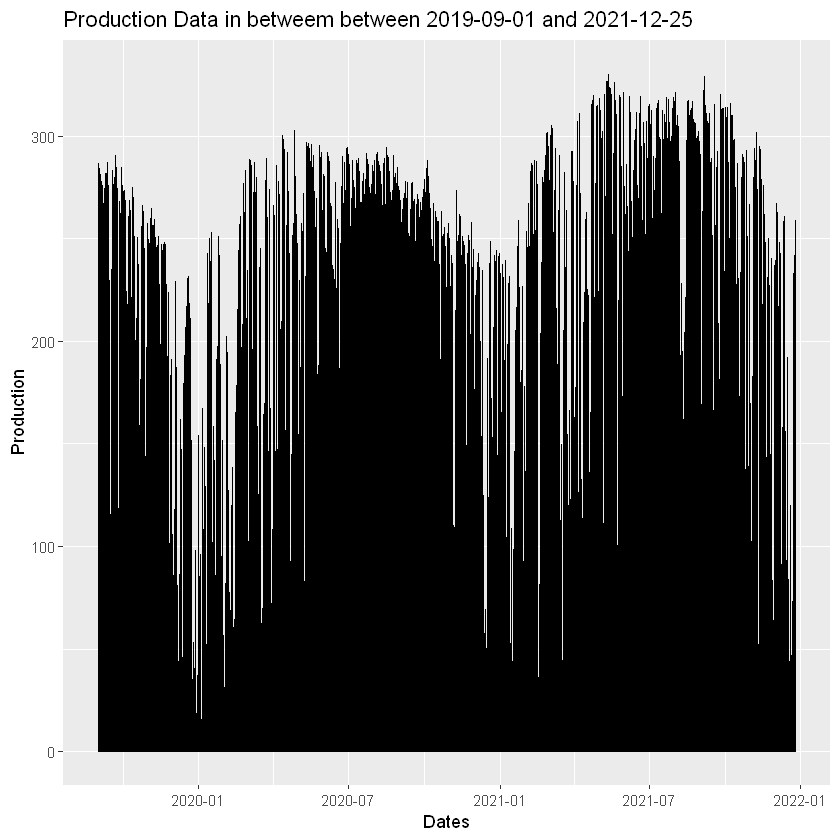

In [31]:
ggplot(data ,aes(x=datetime,y=production)) + geom_line()+
        labs(title="Production Data in betweem between 2019-09-01 and 2021-12-25")+ylab("Production")+xlab("Dates")

By looking the plot, it can be said that there is a trend. So a trend feature will be added to explain trend information in the production.

In [32]:
data[,trend:=1:.N]

## First Model

There are a lot of information and adding all information to model can cause external problems in the dataset, which can cause multi-collinearity in the model. So, we have to analyze our models with forward step-wise direction(by adding new features). In the first model only trend, day, month information will be used. Month information can be replaced by temperature in the next step, the main aim is providing only date information in the first model. In addition, only train dates will be used to understand the situation. Moreover, lagged value(lag48) will also added to explain possible autocorrelation in the residuals of the models.

### Auto-correlation in the lag values

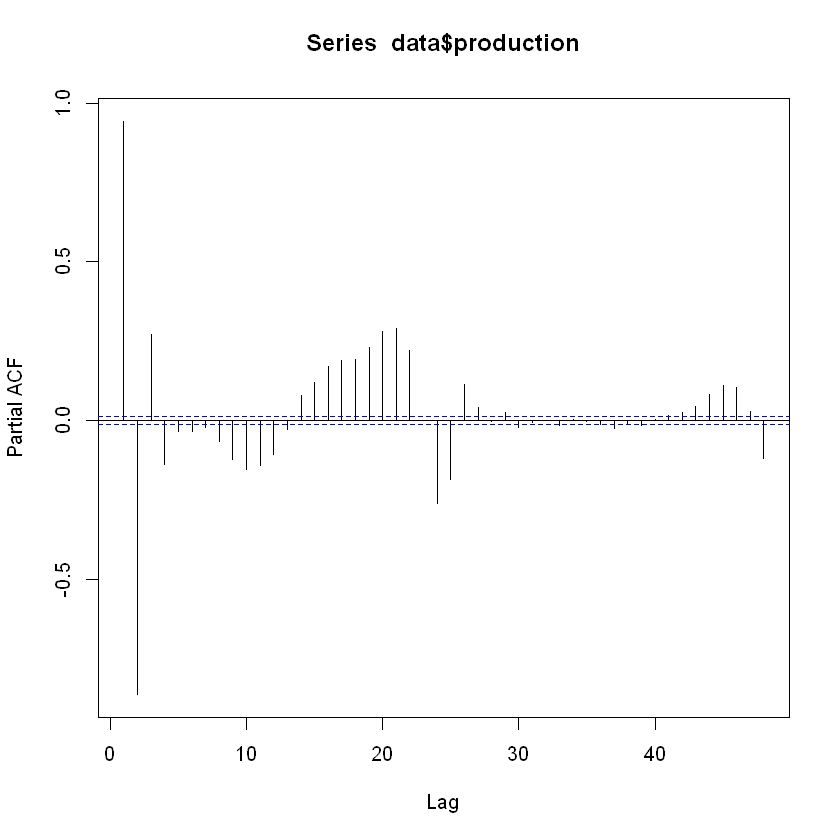

In [33]:
pacf(data$production, 48)

By looking at the table, lag 48 is a good option to add to the model. Much as other possible lag values can be also used, they will not be available when our model predicts the test period.

### Adding Fundamental Features to Dataset

In [34]:
data[,mon:=as.character(month(date,label=T))]
data[,w_day:=as.character(wday(date,label=T))]
data[,lag48:=shift(production,48)]

In [35]:
train=data[date<"2021-11-01"]
test=data[date>="2021-11-01"]

In [36]:
first_model=lm(production~trend+w_day+mon+hour,train)
summary(first_model)


Call:
lm(formula = production ~ trend + w_day + mon + hour, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-111.66  -70.82  -41.38   63.22  248.64 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.418e+01  3.620e+00  20.491  < 2e-16 ***
trend        5.781e-04  1.334e-04   4.335 1.46e-05 ***
w_dayCum    -1.847e+00  2.574e+00  -0.718   0.4730    
w_dayÇar     4.379e-01  2.575e+00   0.170   0.8650    
w_dayPaz     3.352e+00  2.568e+00   1.305   0.1919    
w_dayPer     3.348e-01  2.581e+00   0.130   0.8968    
w_dayPzt     9.242e-01  2.575e+00   0.359   0.7197    
w_daySal     2.425e+00  2.575e+00   0.942   0.3464    
monAra      -5.414e+01  3.561e+00 -15.203  < 2e-16 ***
monEki      -1.785e+01  3.205e+00  -5.569 2.59e-08 ***
monEyl      -8.187e+00  3.230e+00  -2.534   0.0113 *  
monHaz       1.069e+00  3.510e+00   0.304   0.7608    
monKas      -3.250e+01  3.612e+00  -8.999  < 2e-16 ***
monMar      -3.100e+01  3.509e+00  -8.835  < 2

By looking the model it can be said that week_day information has no impact in the production of energy,so this feature will be removed.

### Second LM Model

In [37]:
second_model=lm(production~trend+mon+Temp+DSWRF+RH+TCDC1+TCDC2+hour,train)
summary(second_model)


Call:
lm(formula = production ~ trend + mon + Temp + DSWRF + RH + TCDC1 + 
    TCDC2 + hour, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-194.82  -36.09  -14.42   34.01  209.37 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.282e+01  2.128e+00  38.918  < 2e-16 ***
trend        5.941e-04  7.991e-05   7.435 1.09e-13 ***
monAra       2.838e+01  2.725e+00  10.414  < 2e-16 ***
monEki       2.183e+01  2.027e+00  10.772  < 2e-16 ***
monEyl       1.039e+01  1.942e+00   5.349 8.92e-08 ***
monHaz      -3.986e-01  2.153e+00  -0.185    0.853    
monKas       3.097e+01  2.528e+00  12.250  < 2e-16 ***
monMar       1.811e+01  2.677e+00   6.766 1.36e-11 ***
monMay       5.132e+00  2.187e+00   2.347    0.019 *  
monNis       1.179e+01  2.458e+00   4.799 1.61e-06 ***
monOca       2.748e+01  2.939e+00   9.351  < 2e-16 ***
monŞub       2.619e+01  2.984e+00   8.777  < 2e-16 ***
monTem      -5.138e+00  2.091e+00  -2.457    0.014 *  
Temp         

### Visual Control of Obtained Model

In [38]:
lm2_model_dt=data.table(date=train$datetime, actual=train$production, predicted=predict(second_model,train))

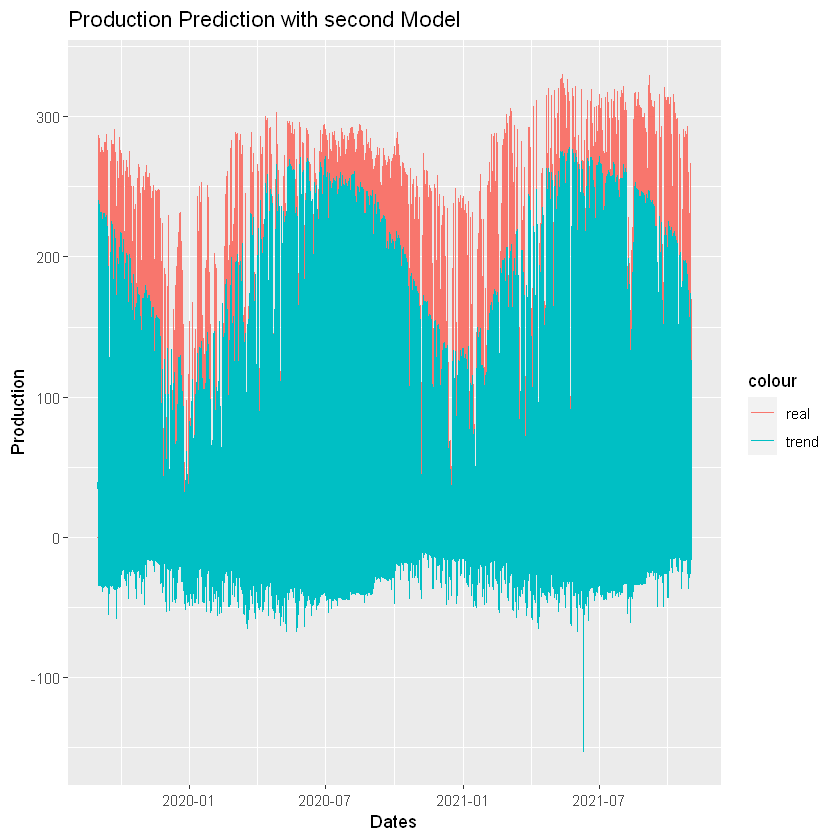

In [39]:
ggplot(lm2_model_dt ,aes(x=date)) +
        geom_line(aes(y=actual,color='real')) + 
        geom_line(aes(y=predicted,color='trend'))+
        labs(title="Production Prediction with second Model")+ylab("Production")+xlab("Dates")

### Residual Control

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

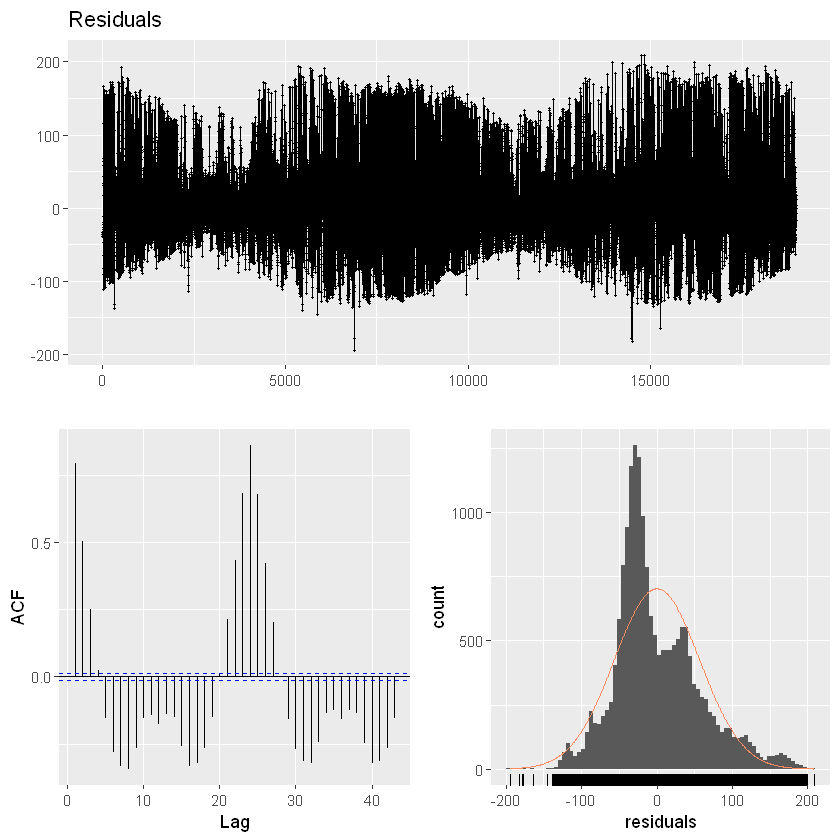

In [40]:
checkresiduals(second_model$residuals)

There are some requirements in the linear regression model and some of them violeted in this model. First of all, there are a auto-correlation in between the residuals. We can handle it by adding lagged values. lag48 will be used in this manner. In addition, it is hard to say that residuals of the model resembles a normal distribution. Lastly, variance of the residuals are not constant in the model. So, this model violets some rule of the linear regression.

### Third LM Model

In [41]:
third_model=lm(production~trend+mon+Temp+DSWRF+RH+TCDC1+TCDC2+hour+lag48,train)
summary(third_model)


Call:
lm(formula = production ~ trend + mon + Temp + DSWRF + RH + TCDC1 + 
    TCDC2 + hour + lag48, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-219.777  -15.908   -3.473   13.303  206.676 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.225e+01  1.362e+00  16.343  < 2e-16 ***
trend        1.100e-04  4.969e-05   2.213 0.026918 *  
monAra       1.099e+01  1.688e+00   6.511 7.67e-11 ***
monEki       5.665e+00  1.257e+00   4.508 6.57e-06 ***
monEyl       2.644e+00  1.206e+00   2.193 0.028340 *  
monHaz       1.349e+00  1.331e+00   1.014 0.310782    
monKas       6.617e+00  1.570e+00   4.215 2.51e-05 ***
monMar       7.909e+00  1.656e+00   4.775 1.81e-06 ***
monMay       4.655e+00  1.352e+00   3.443 0.000577 ***
monNis       9.280e+00  1.520e+00   6.107 1.04e-09 ***
monOca       9.259e+00  1.820e+00   5.087 3.68e-07 ***
monŞub       7.873e+00  1.848e+00   4.259 2.06e-05 ***
monTem      -2.178e+00  1.293e+00  -1.684 0.092151

### Visual Control of Obtained Model

In [42]:
lm3_model_dt=data.table(date=train$datetime, actual=train$production, predicted=predict(third_model,train))

Warning message:
"Removed 48 row(s) containing missing values (geom_path)."

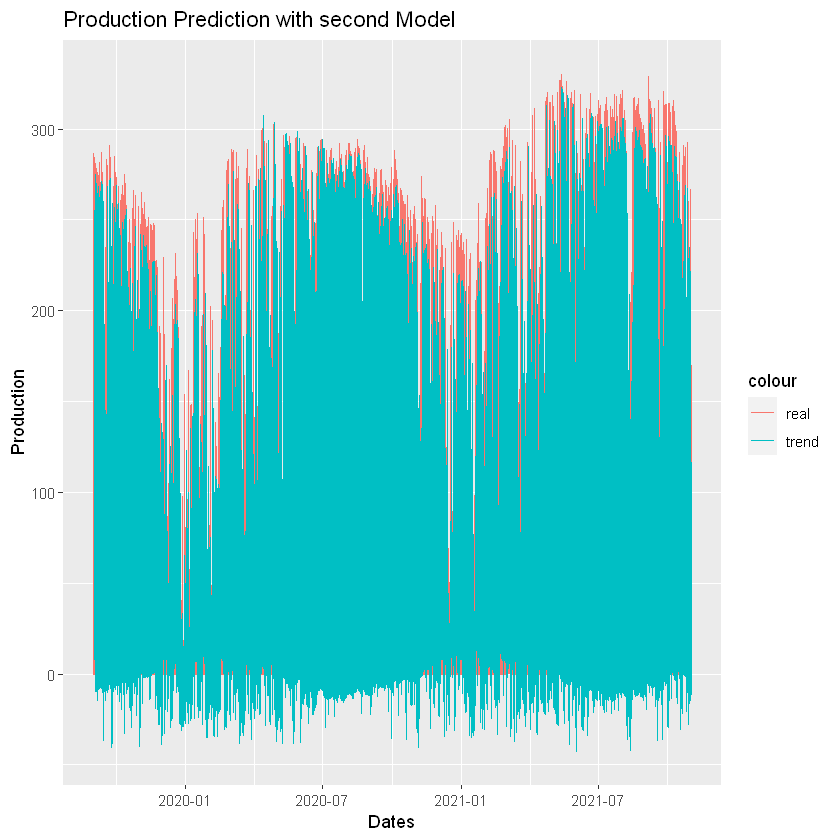

In [43]:
ggplot(lm3_model_dt ,aes(x=date)) +
        geom_line(aes(y=actual,color='real')) + 
        geom_line(aes(y=predicted,color='trend'))+
        labs(title="Production Prediction with second Model")+ylab("Production")+xlab("Dates")

### Residual Control

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

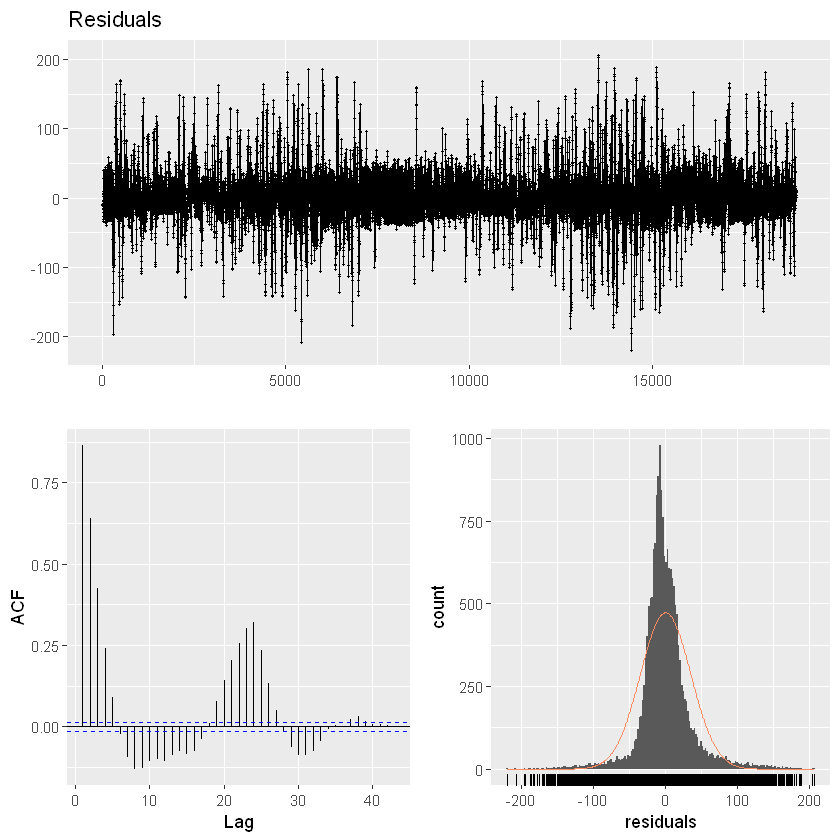

In [44]:
checkresiduals(third_model$residuals)

Much as there are some problems in the third linear regression model, there is a huge amount of improvement. First of all, residuals resemble white noise. In other words, the variance of the residuals is constant and it has zero mean. In addition, the distribution of residuals is approximate to the normal distribution. I will assume that the current model is enough and we removed garbage in garbage out problem with current features, so I continue to the regression tree-based approach to explaining problems in the model.

In addition, the model predicts below zero in some cases, which must be also controlled to get logical predictions in the estimations.

## EBLR

In [45]:
train[, predicted:=predict(third_model,train)]
train[, residual:=production-predicted]

Lagged value will be removed by assuming, it is impossible to predict lag48 value in this case because this fature cannot be obtained in the test period.

### First Iteration

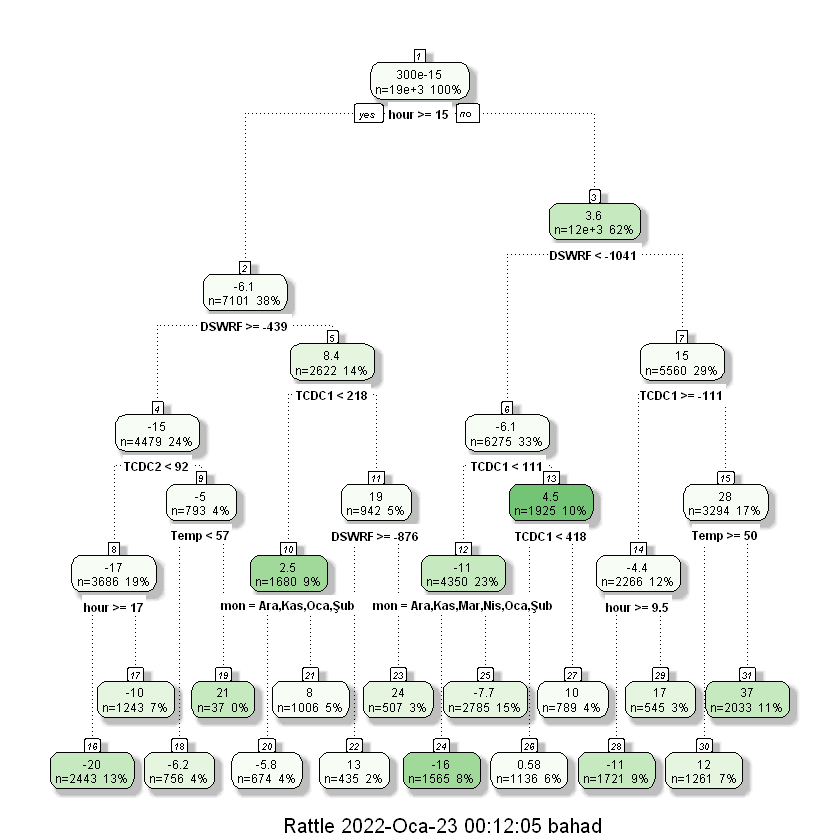

In [46]:
fit_res_tree1=rpart(residual~trend+mon+Temp+DSWRF+RH+TCDC1+TCDC2+hour,train,
                   control=rpart.control(cp=0,maxdepth=4))

fancyRpartPlot(fit_res_tree1)

By looking at the tree, the seventh node is good to give the model to explain the problem in this specific case. By looking at the node, it can be said that hour and DSWRF have interaction. So, we have to add this feature to the model. Path of 7'th node will be added to the model by creating new features. This node selected by looking the color and details(number of instance and residual value) of the node.

In [47]:
train[,hour15_less:=as.numeric(hour<=15)]
train[,DSWRF_n1041_above:=as.numeric(DSWRF>-1041)]

In [48]:
third_model_v2=lm(production~trend+mon+Temp+DSWRF+RH+TCDC1+TCDC2+hour+lag48+hour15_less:DSWRF_n1041_above,train)
summary(third_model_v2)


Call:
lm(formula = production ~ trend + mon + Temp + DSWRF + RH + TCDC1 + 
    TCDC2 + hour + lag48 + hour15_less:DSWRF_n1041_above, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-205.722  -13.503   -0.663   15.813  154.480 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.702e+01  1.230e+00  13.842  < 2e-16 ***
trend                          2.960e-04  4.486e-05   6.597 4.30e-11 ***
monAra                         8.565e+00  1.522e+00   5.629 1.84e-08 ***
monEki                         5.560e+00  1.132e+00   4.910 9.19e-07 ***
monEyl                         3.430e+00  1.087e+00   3.156  0.00160 ** 
monHaz                         2.230e+00  1.200e+00   1.859  0.06305 .  
monKas                         7.243e+00  1.415e+00   5.120 3.08e-07 ***
monMar                         8.339e+00  1.493e+00   5.587 2.34e-08 ***
monMay                         5.262e+00  1.219e+00   4.318 1.58e-05 ***
mon

In [49]:
lm3_model_dt_v2=data.table(date=train$datetime, actual=train$production, predicted=predict(third_model_v2,train))

Warning message:
"Removed 48 row(s) containing missing values (geom_path)."

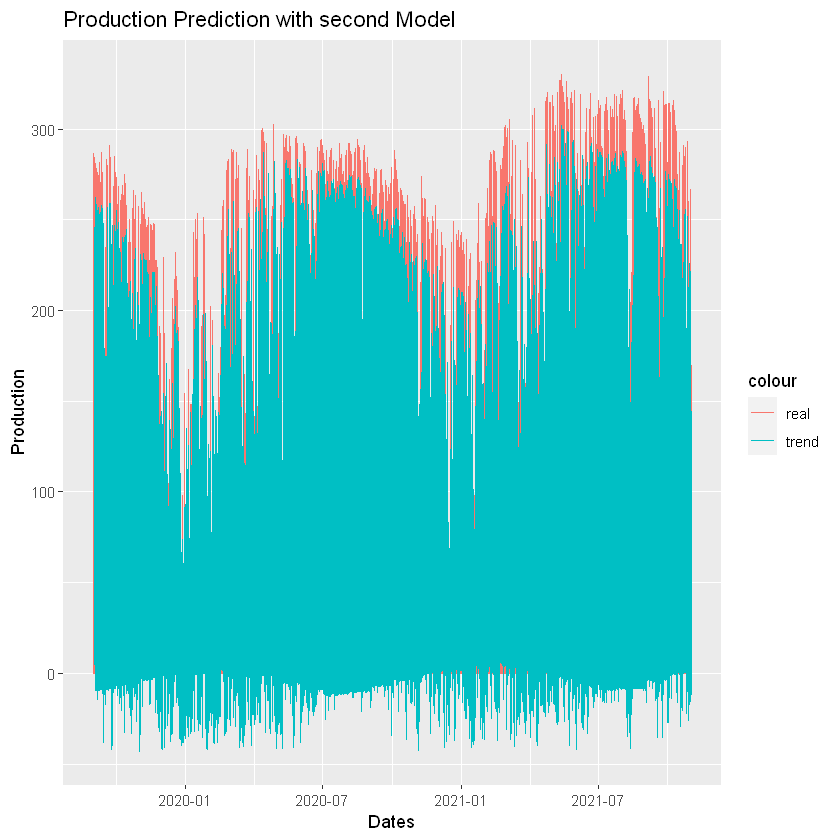

In [50]:
ggplot(lm3_model_dt_v2 ,aes(x=date)) +
        geom_line(aes(y=actual,color='real')) + 
        geom_line(aes(y=predicted,color='trend'))+
        labs(title="Production Prediction with second Model")+ylab("Production")+xlab("Dates")

### Residual Control

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

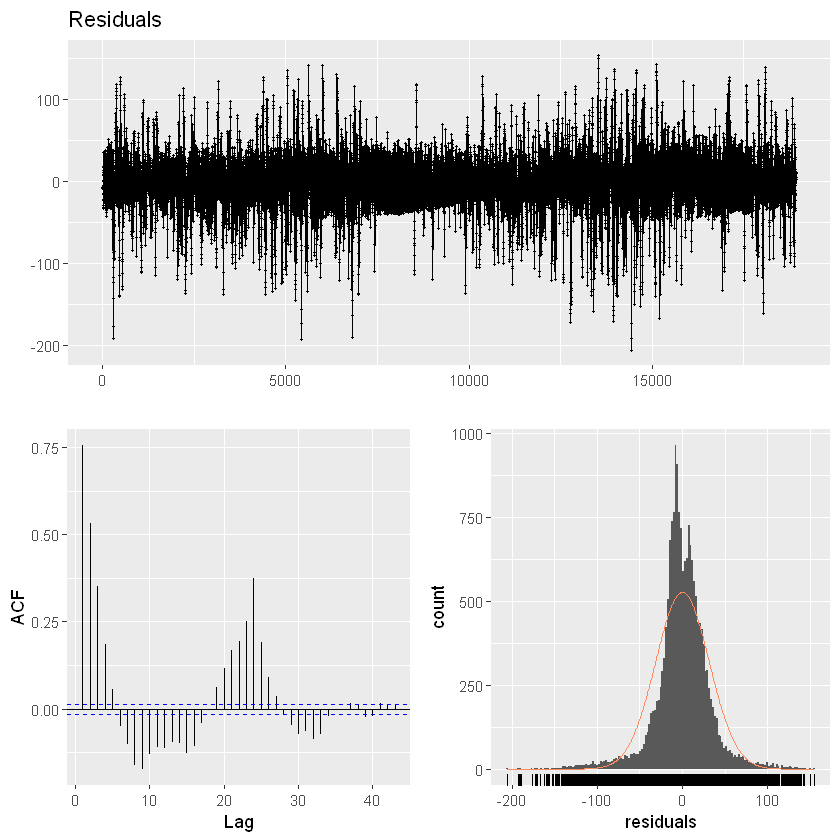

In [51]:
checkresiduals(third_model_v2$residuals)

Obtained results are very similar in third_model and third_model_v2. Adjusted R square values of the models are 0.87 and 0.8944 sequentially. In addition, training performance that does not improve within a ratio of 1% will be assumed as performance in the R square value, as accepted in the lecture. So, I will inspect this value to determine to stop the iterations. In the current step, the difference is 0.0244 and it exceeds 1 percentage(2.8) increase, so another step will be controlled. 

### Second Iteration

In [52]:
train[, predicted2:=predict(third_model_v2,train)]
train[, residual:=production-predicted2]

Lagged value will be removed by assuming, it is impossible to predict lag48 value in this case because this fature cannot be obtained in the test period.

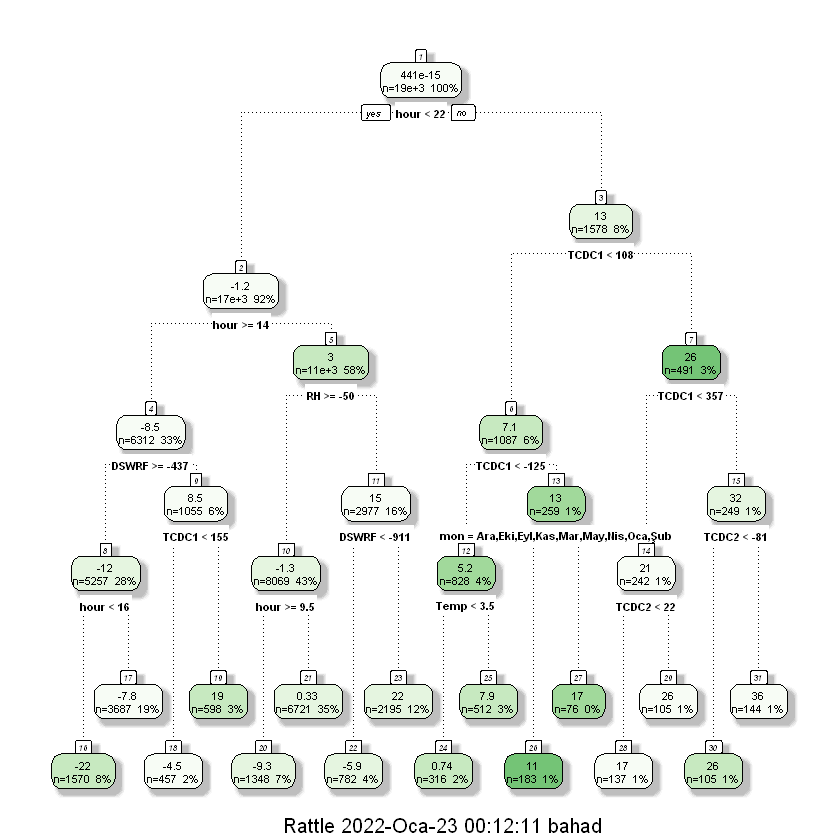

In [53]:
fit_res_tree1=rpart(residual~trend+mon+Temp+DSWRF+RH+TCDC1+TCDC2+hour,train,
                   control=rpart.control(cp=0,maxdepth=4))

fancyRpartPlot(fit_res_tree1)

By looking the tree, seventh node is good to give the model to explain problem in this specific case. By looking the nodes, it can be said that hour and TCDC1 have interaction. So, we have to add this feature to model. Path of 7'th node will be added to model by creating new features. This node selected by looking the color and details(number of instance and residual value) of the node.

In [54]:
train[,hour22_above:=as.numeric(hour>22)]
train[,TCDC1_108_above:=as.numeric(TCDC1>108)]

In [55]:
third_model_v3=lm(production~trend+mon+Temp+DSWRF+RH+TCDC1+TCDC2+hour+lag48+hour15_less:DSWRF_n1041_above+ hour22_above:TCDC1_108_above,train)
summary(third_model_v3)


Call:
lm(formula = production ~ trend + mon + Temp + DSWRF + RH + TCDC1 + 
    TCDC2 + hour + lag48 + hour15_less:DSWRF_n1041_above + hour22_above:TCDC1_108_above, 
    data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-205.713  -13.506   -0.611   15.596  153.361 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.802e+01  1.226e+00  14.703  < 2e-16 ***
trend                          2.980e-04  4.464e-05   6.675 2.55e-11 ***
monAra                         8.954e+00  1.514e+00   5.913 3.42e-09 ***
monEki                         5.798e+00  1.127e+00   5.145 2.70e-07 ***
monEyl                         3.584e+00  1.081e+00   3.314 0.000921 ***
monHaz                         2.313e+00  1.194e+00   1.937 0.052711 .  
monKas                         7.636e+00  1.408e+00   5.424 5.92e-08 ***
monMar                         8.491e+00  1.485e+00   5.717 1.10e-08 ***
monMay                         5.254e+00

In [56]:
lm3_model_dt_v3=data.table(date=train$datetime, actual=train$production, predicted=predict(third_model_v3,train))

Warning message:
"Removed 48 row(s) containing missing values (geom_path)."

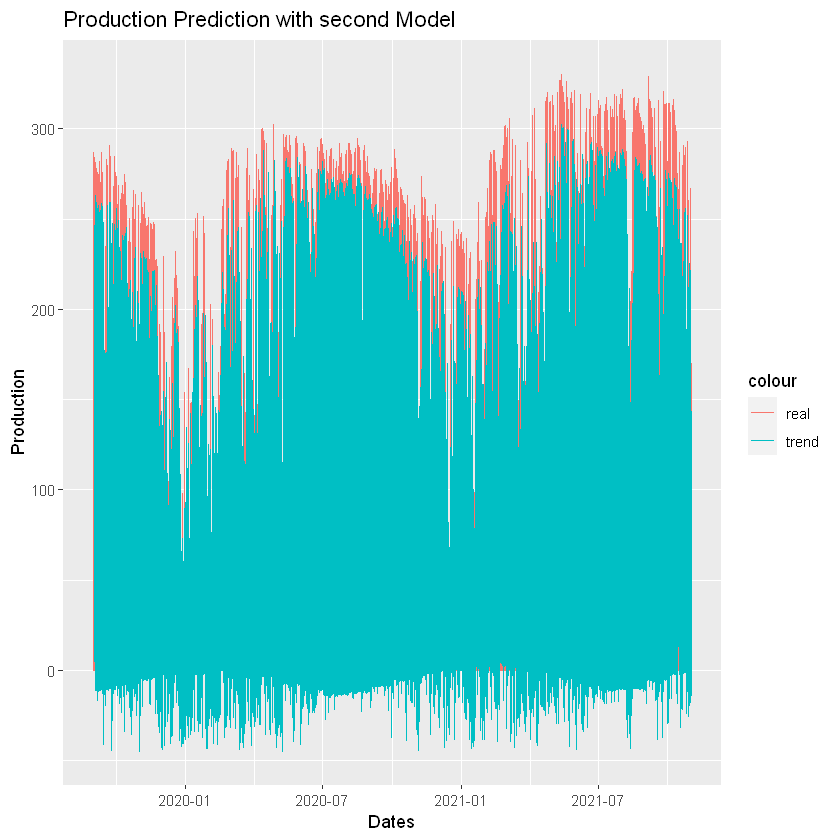

In [57]:
ggplot(lm3_model_dt_v3 ,aes(x=date)) +
        geom_line(aes(y=actual,color='real')) + 
        geom_line(aes(y=predicted,color='trend'))+
        labs(title="Production Prediction with second Model")+ylab("Production")+xlab("Dates")

### Residual Control

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

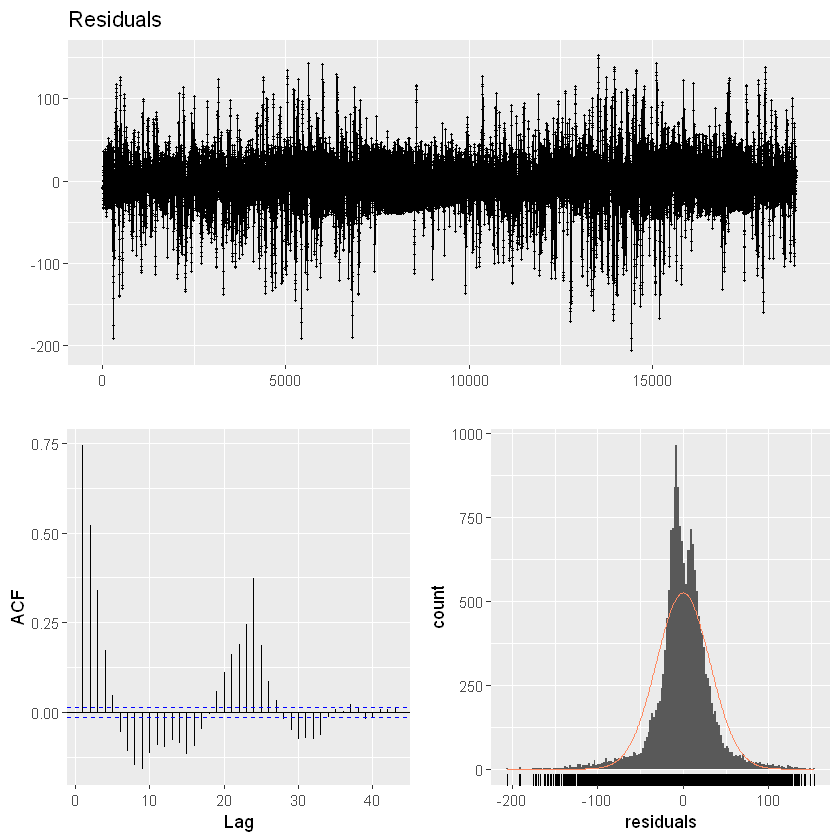

In [58]:
checkresiduals(third_model_v3$residuals)

Obtained results are very similar in third_model_v2 and third_model_v3. Adjusted R square values of the models are 0.8944 and 0.8955 sequentially. In addition, training performance does not improve within a ratio of 1% will be assumed as performance in the R square value, as accepted in the lecture. So, I will inspect this value to determine to stop the iterations. In the current step, difference is 0.00109 and it does not exceed 1 percentage(0.00121) improvement, so I will stop in this step. 

<a id="4"></a>
# Predictions with Obtained Model

A sliding window technique will be used to get the performance of the model. In addition, multiple linear regression models will be created after slicing the data. Lastly, below zero production is impossible for our case, so negative values will be removed by considering this fact.

Obtained features with EBLR will be added to the initial data, and the model will be split to train and test. Then predictions will be conducted with the slicing windows technique.

### First Obtained Feature

In [59]:
data[,hour15_less:=as.numeric(hour<=15)]
data[,DSWRF_n1041_above:=as.numeric(DSWRF>-1041)]

### Second Obtained Feature

In [60]:
data[,hour22_above:=as.numeric(hour>22)]
data[,TCDC1_108_above:=as.numeric(TCDC1>108)]

In [61]:
train=data[date<"2021-11-01"]
test=data[date>="2021-11-01"]

### Initial Test Date

In [62]:
test_start=as.Date("2021-11-01")

## Model with Slicing Window Technique

In [64]:
results_feature_reg=vector("list",nrow(test)-48)
count=1
reg_time_feat=Sys.time()
for(i in 1:(nrow(test[,.N,by=date])+1)){
    current_date=test_start+i-2
    train_data=data[date<current_date]
    test_data=data[date==current_date+1]
    control=0   
    # Predictions
    lm_model=lm(production~trend+mon+Temp+DSWRF+RH+TCDC1+TCDC2+hour+lag48+
                      hour15_less:DSWRF_n1041_above+ hour22_above:TCDC1_108_above, data=train_data)
    current_res=predict(lm_model,newdata=test_data)
    if(is.na(current_res[1])){
        next
        
    }
    for(j in 1:24){
        current_res=pmax(current_res,0) # Remove negative values        
        results_feature_reg[count]=current_res[j]
        count=count+1     
        
    }
}
reg_time_feat=Sys.time()-reg_time_feat

In [65]:
res_dt_regression_feature=t(rbind(results_feature_reg))
res_dt_regression_feature=as.data.table(res_dt_regression_feature)

In [66]:
setnames(res_dt_regression_feature,"results_feature_reg","Forescasted")

In [67]:
final_res_feat_regression=test[,c(1,3)]

In [68]:
final_res_feat_regression$forecast=as.numeric(res_dt_regression_feature$Forescasted)

### Obtained Prediction Table

In [69]:
final_res_feat_regression

date,production,forecast
2021-11-01,0.0000,14.899278
2021-11-01,0.0000,13.817743
2021-11-01,0.0002,12.612244
2021-11-01,0.0001,10.283280
2021-11-01,0.0157,0.000000
2021-11-01,0.0000,0.000000
2021-11-01,0.4898,1.056423
2021-11-01,9.7539,9.526774
2021-11-01,60.2989,46.504249
2021-11-01,74.6414,149.334911


### Performance of the Modified Regression Model

In [70]:
perf_dt("Performance of Final Linear Regression with Slicing Window", final_res_feat_regression$production, as.numeric(final_res_feat_regression$forecast))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Performance of Final Linear Regression with Slicing Window,1296,45.46808,79.29,-0.07390014,NaN,0.9744177,20.05417,0.4410604


<a id="5"></a>
# Base Model

In [71]:
data[, lag48:=shift(production,48)]

In [72]:
perf_dt("Performance of Base Model(Lag 48)", final_res_feat_regression$production, data[date>="2021-11-01", lag48])

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Performance of Base Model(Lag 48),1296,45.46808,79.29,0.00221219,NaN,1.435908,22.94308,0.5045976


<a id="6"></a>
# Results

By looking at the obtained result table, there is an important performance increase in the model. In terms of WMAPE value, there is a 12.59% performance increase in the predictions. However, this improvement can be ignored if there is limited time to get a prediction. In other words, lag 48 is still a valid approach to predict the production of the facility at t+1. 

In addition, 17'th December did not exist in the given file. So, I removed this day prediction in the test period by adding an if function into the slicing window function.

<a id="7"></a>
# Last Comments and Conclusion

In this homework, I updated my final exam notebook by controlling my functions and adding new comments. In general, Na values were held at the beginning of the notebook. Then, a correlation analysis was made to prevent multicollinearity problems in the linear regression. In addition, the PCA technique was used to get new features to represent correlated features. Minimum 75% variance explanation was held for all features. After that, a basic linear regression model was created by looking at fundamental date information like day and month. Insignificance information was removed and other possible features were added into the second model. Lastly, a lag 48 value is added after finding an auto-correlation problem in the residuals of the second linear regression. The third linear regression model is nearly proper for assumptions of the linear regression, so it is selected as the final linear regression model.

Then, the EBLR technique is used to understand the existing non-linear relation of the features to explain target variables. 2 steps are held to get better model input. Hour-DSWRF and Hour-TCDC1 have some relations in this manner, and these circumstances added to the model by creating new features. After obtaining an adequate model as described in the description of exam/homework, the model predicted production values of the determined interval(2021-11-01 to 2021-12-25) with a sliding window technique. Lastly, obtained predictions are compared with a base model prediction(lag48) by using WMAPE values. A 12.59% performance increase was obtained in WMAPE values by constructing this model.